In [1]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
import subprocess

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

In [2]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--     5
100 9499k  100 9499k    0     0  3769k      0  0:00:02  0:00:02 --:--:-- 8161k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

In [3]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
specky_table.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song


In [4]:
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]
specky_table.head()

,filename,woodcock,sound_type
0,./woodcock_labeled_data/d4c40b6066b489518f8da8...,present,song
1,./woodcock_labeled_data/e84a4b60a4f2d049d73162...,absent,na
2,./woodcock_labeled_data/79678c979ebb880d5ed6d5...,present,song
3,./woodcock_labeled_data/49890077267b569e142440...,present,song
4,./woodcock_labeled_data/0c453a87185d8c7ce05c5c...,present,song


In [5]:
# create a new dataframe with the filenames from the previous table as the index
labels = pd.DataFrame(index=specky_table['filename'])

#convert 'present' to 1 and 'absent' to 0
labels['woodcock']=[1 if l=='present' else 0 for l in specky_table['woodcock']]

In [6]:
from sklearn.model_selection import train_test_split
train_df,validation_df = train_test_split(labels,test_size=0.2,random_state=1)

In [32]:
from opensoundscape.torch.models.cnn import load_model
import os

# Define constants
SAMPLE_DURATION = 10.0
NUM_EPOCHS = 15
BATCH_SIZE = 10
SAVE_INTERVAL = 150

# Specify paths
model_path = './bird_training/best.model'
save_path = './bird_training/'

# Create model object
classes = train_df.columns #in this case, there's just one class: ["woodcock"]

if os.path.exists(model_path):
    model = load_model(model_path)
else:
    model = CNN('resnet18', classes=classes, sample_duration=SAMPLE_DURATION)

model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path=save_path,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    save_interval=SAVE_INTERVAL,
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
)

model.save(model_path)
model = load_model(model_path)



Training Epoch 105
Epoch: 105 [batch 0/3 (0.00%)] 
	DistLoss: 0.681
Metrics:
Metrics:
	MAP: 0.853

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 106
Epoch: 106 [batch 0/3 (0.00%)] 
	DistLoss: 0.526
Metrics:
Metrics:
	MAP: 0.927

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 107
Epoch: 107 [batch 0/3 (0.00%)] 
	DistLoss: 0.488
Metrics:
Metrics:
	MAP: 0.860

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 108
Epoch: 108 [batch 0/3 (0.00%)] 
	DistLoss: 0.399
Metrics:
Metrics:
	MAP: 0.946

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 109
Epoch: 109 [batch 0/3 (0.00%)] 
	DistLoss: 0.448
Metrics:
Metrics:
	MAP: 0.956

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 110
Epoch: 110 [batch 0/3 (0.00%)] 
	DistLoss: 0.494
Metrics:
Metrics:
	MAP: 0.910

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 111
Epoch: 111 [batch 0/3 (0.00%)] 
	DistLoss: 0.425
Metrics:
Metrics:
	MAP: 0.899

Validation.
[]
Metrics:
	MAP: 1.000

Training Epoch 112
Epoch: 112 [batch 0/3 (0.00%

Text(0, 0.5, 'loss')

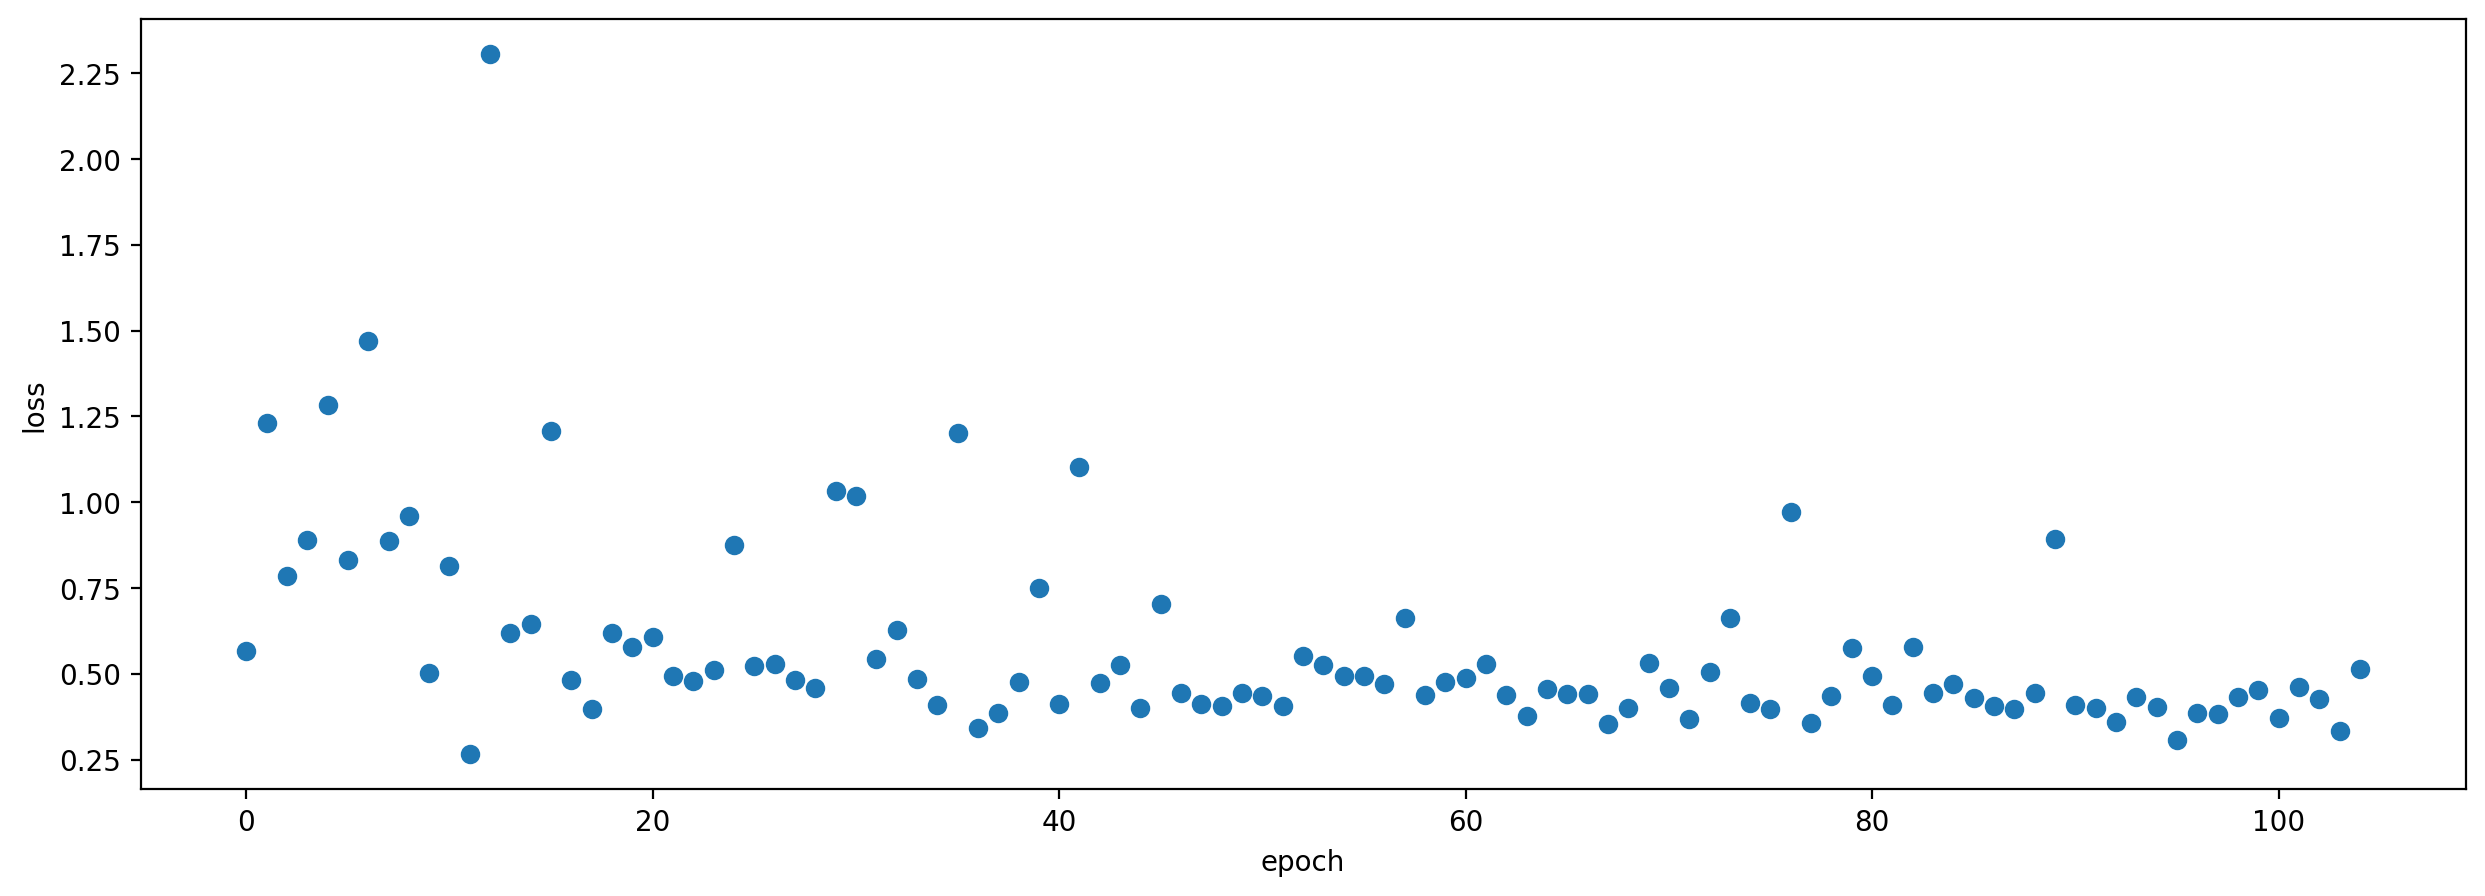

In [26]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [27]:
from glob import glob
field_recordings = glob('./*.WAV')
field_recordings

['./20220601_053000.WAV',
 './20220601_063000.WAV',
 './20220601_083000.WAV',
 './20220601_073000.WAV']

In [28]:
#WORKING FOR OVERALL
import os

#write to csv
# Predict on audio files
valid_scores = model.predict(
    field_recordings,
    activation_layer='sigmoid',
    split_files_into_clips=False
    #idk what the difference is between True or False here ^
)

# Extract the DataFrame from the tuple and remove unnecessary elements
scores_df = valid_scores[0]
scores_df.index = [os.path.basename(f) for f in field_recordings]

# Add a new column 'Presence' based on the value of 'woodcock' column
scores_df['Presence'] = ['Present' if score > 0.9 else 'Absent' for score in scores_df['woodcock']]

# Save the DataFrame to a CSV file
scores_df.to_csv('copyWoodcock.csv')

[]


In [31]:
#all with overlap
import os
# import Audio and Spectrogram classes from OpenSoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram



#predict method returns a LIST of dataframes, so in this case, prediction_scores_df is list of one dataframe
prediction_scores_df = model.predict(field_recordings, activation_layer='sigmoid', overlap_fraction = .5)



# Add a new column 'Presence' based on the value of 'woodcock' column
prediction_scores_df[0]['Presence'] = ['Present' if float(score) > 0.9 else '' for score in prediction_scores_df[0]['woodcock']]



prediction_scores_df[0].to_csv("copy_withOverlap.csv")

[]
